## Credit Card Fraud Detection

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from time import strptime

plt.rcParams['figure.figsize'] = (15, 10)
pd.options.display.max_columns = 50

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda_latest\envs\creditcardfrauddetection\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('fraudTrain.csv')

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df['cc_num'].nunique()

983

In [5]:
df['zip'].nunique()
df['trans_date_trans_time'].nunique()

1274791

In [6]:
len(df['trans_num'])

1296675

In [7]:
len(df)

1296675

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [9]:
# Defining functions to extract date and time of features

def date_time_extractor(data):  
    date = pd.to_datetime(data)    
    return date

In [10]:
# This cell can take about 5-10 minutes depending on the speed of the processor
df['transaction_date'] = df['trans_date_trans_time'].apply(date_time_extractor)

In [11]:
# Extracting individual features from dates and times derived earlier
df['year'] = df['transaction_date'].dt.year
df['month'] = df['transaction_date'].dt.month
df['day'] = df['transaction_date'].dt.day

# Extracting hour, minute and second from the data
df['hour'] = df['transaction_date'].dt.hour
df['minute'] = df['transaction_date'].dt.minute
df['second'] = df['transaction_date'].dt.second

In [12]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,transaction_date,year,month,day,hour,minute,second
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18,2019,1,1,0,0,18
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,2019,1,1,0,0,44
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51,2019,1,1,0,0,51
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16,2019,1,1,0,1,16
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06,2019,1,1,0,3,6


In [13]:
# Dropping columns that are not important
df.drop(['Unnamed: 0', 'street', 'dob', 
         'trans_date_trans_time', 'trans_num', 
         'unix_time', 'transaction_date'],
       axis = 1, inplace = True)

In [14]:
df.head()

,cc_num,merchant,category,amt,first,last,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,year,month,day,hour,minute,second
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,2019,1,1,0,0,18
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,2019,1,1,0,0,44
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0,2019,1,1,0,0,51
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,2019,1,1,0,1,16
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,2019,1,1,0,3,6


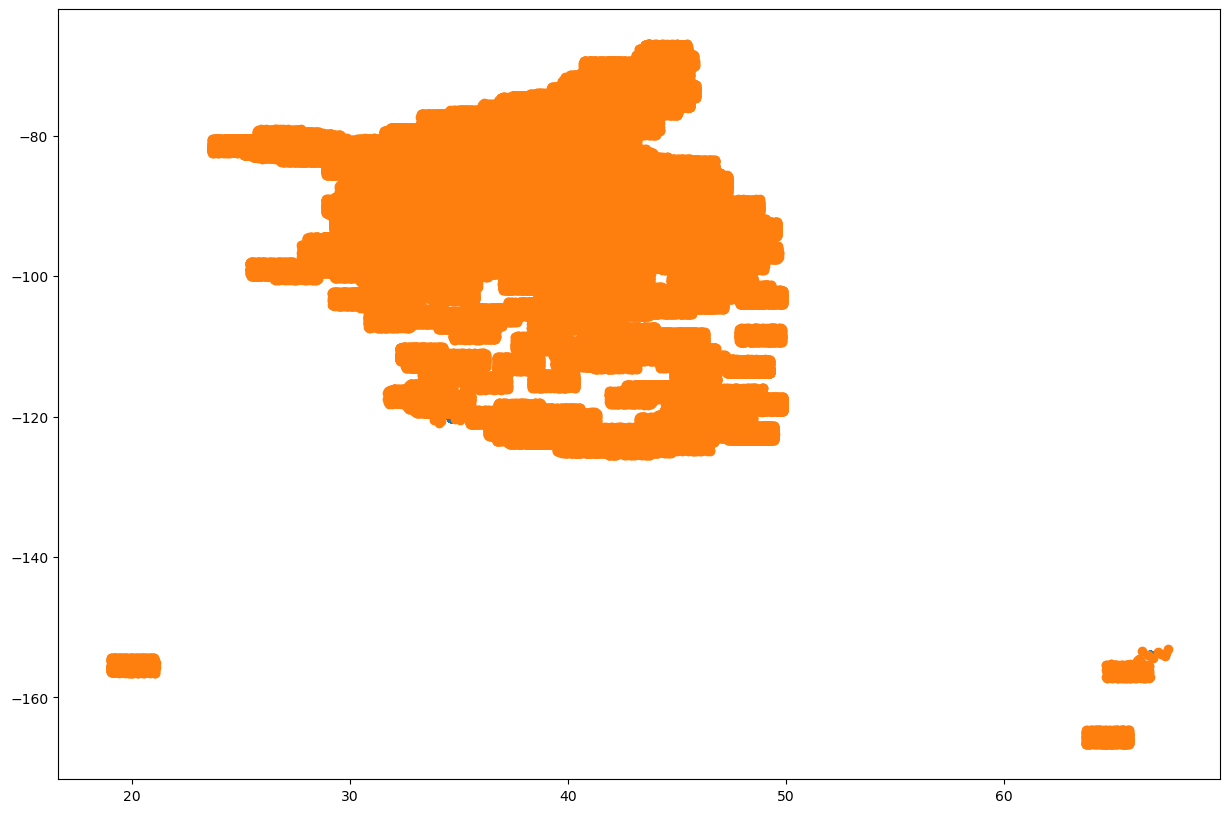

In [15]:
# Plotting long and latitude along with merchant longitude and latitude (coordinates)
plt.scatter(df['lat'], df['long'])
plt.scatter(df['merch_lat'], df['merch_long'])
plt.show()

In [16]:
categorical_features = ['merchant','category', 'cc_num', 'first', 'last', 'gender', 
                        'city', 'state', 'job','zip', 'year', 'month', 'day',
                       'hour', 'minute', 'second']

df_categorical = df[categorical_features]

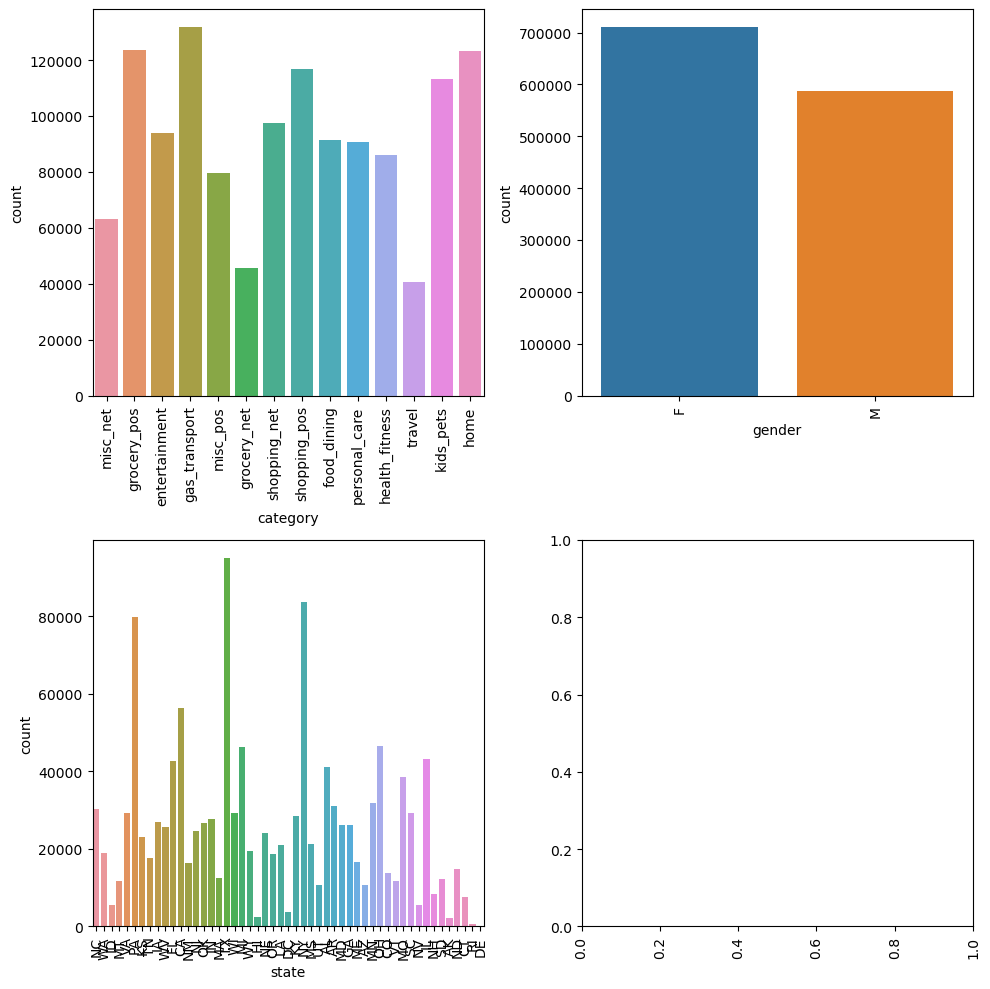

In [17]:
# This code cell plots the count of each of the categories with countplots
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

sns.countplot(x = 'category', data = df_categorical, ax = ax[0, 0])
sns.countplot(x = 'gender', data = df_categorical, ax = ax[0, 1])
sns.countplot(x = 'state', data = df_categorical, ax = ax[1, 0])

# Rotate x-tick labels by 45 degrees for all subplots
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=90)
    
plt.tight_layout()
plt.show()

<AxesSubplot: >

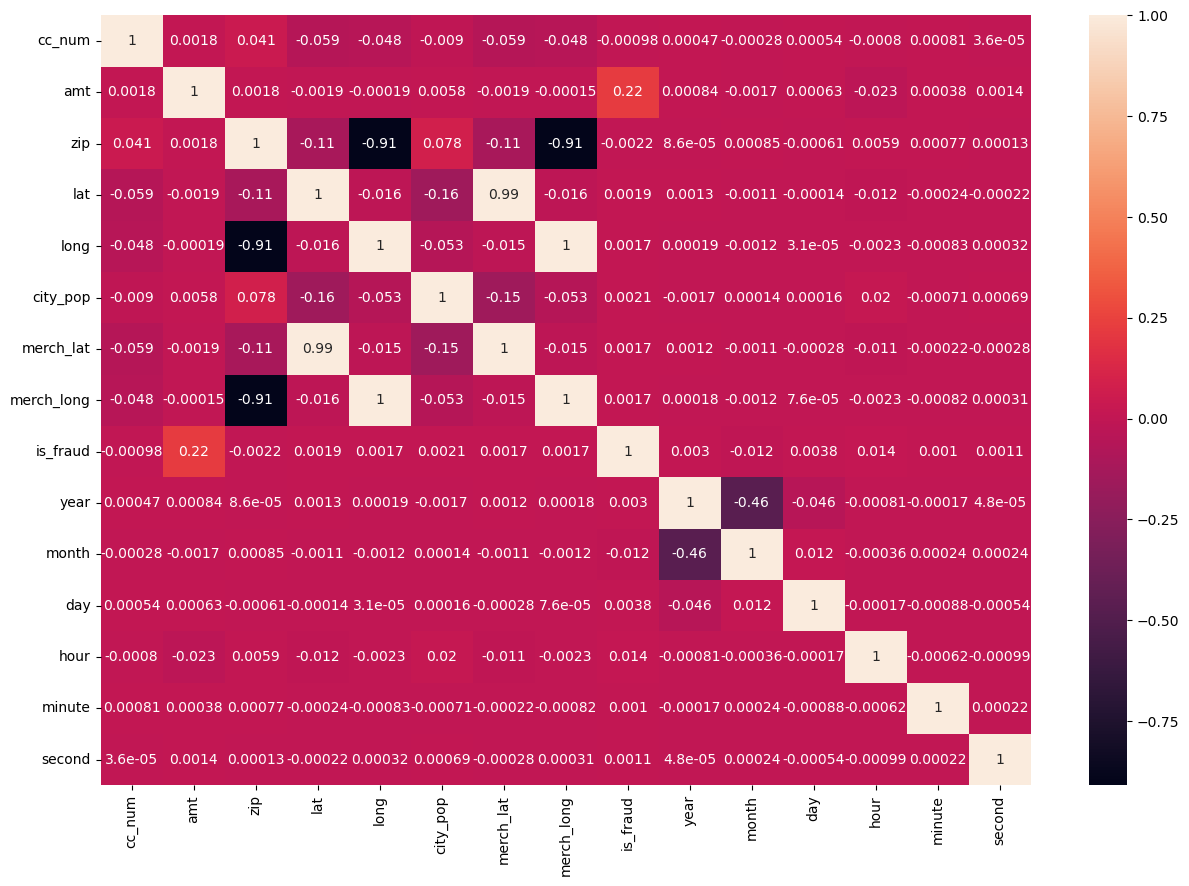

In [18]:
sns.heatmap(df.corr(), annot = True)

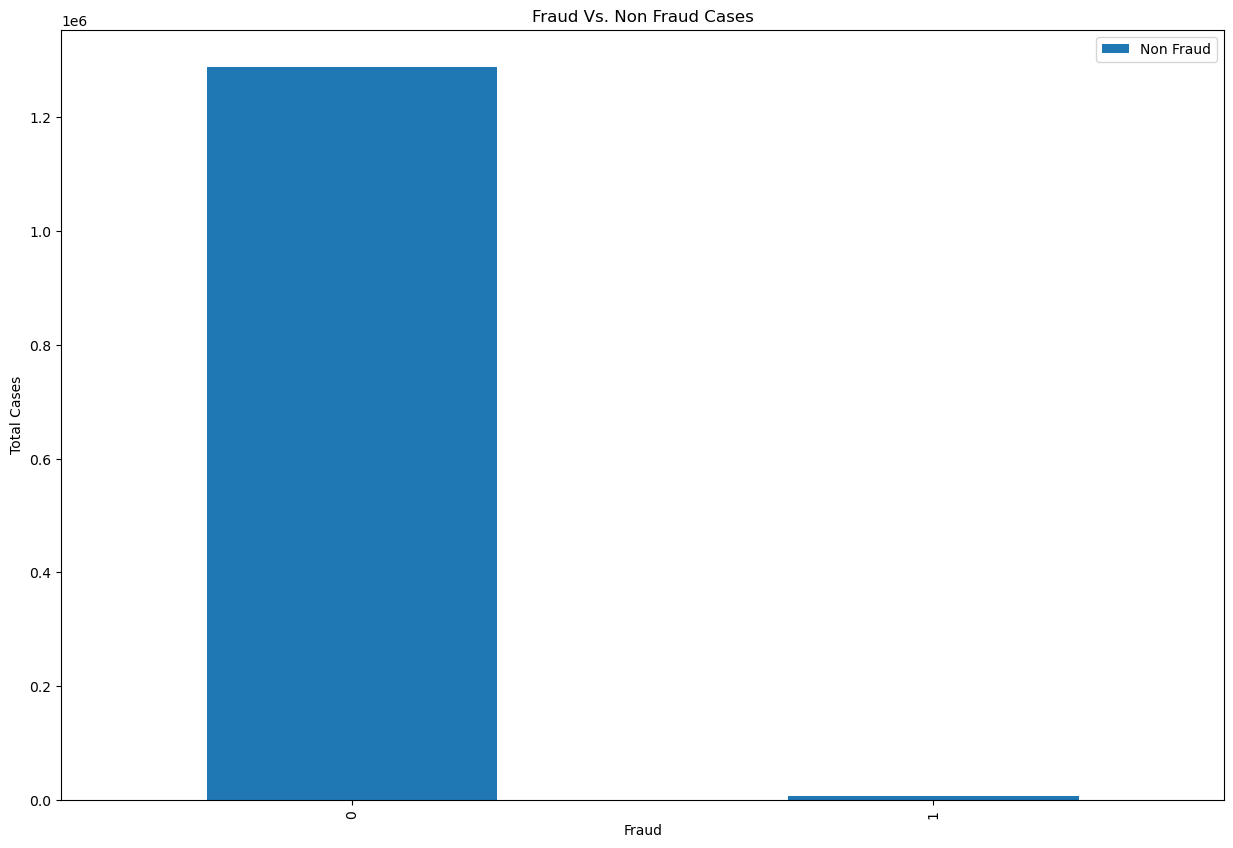

In [19]:
df['is_fraud'].value_counts().plot(kind = 'bar')
plt.title("Fraud Vs. Non Fraud Cases")
plt.xlabel("Fraud")
plt.ylabel("Total Cases")
plt.legend(['Non Fraud', 'Fraud'])
plt.show()

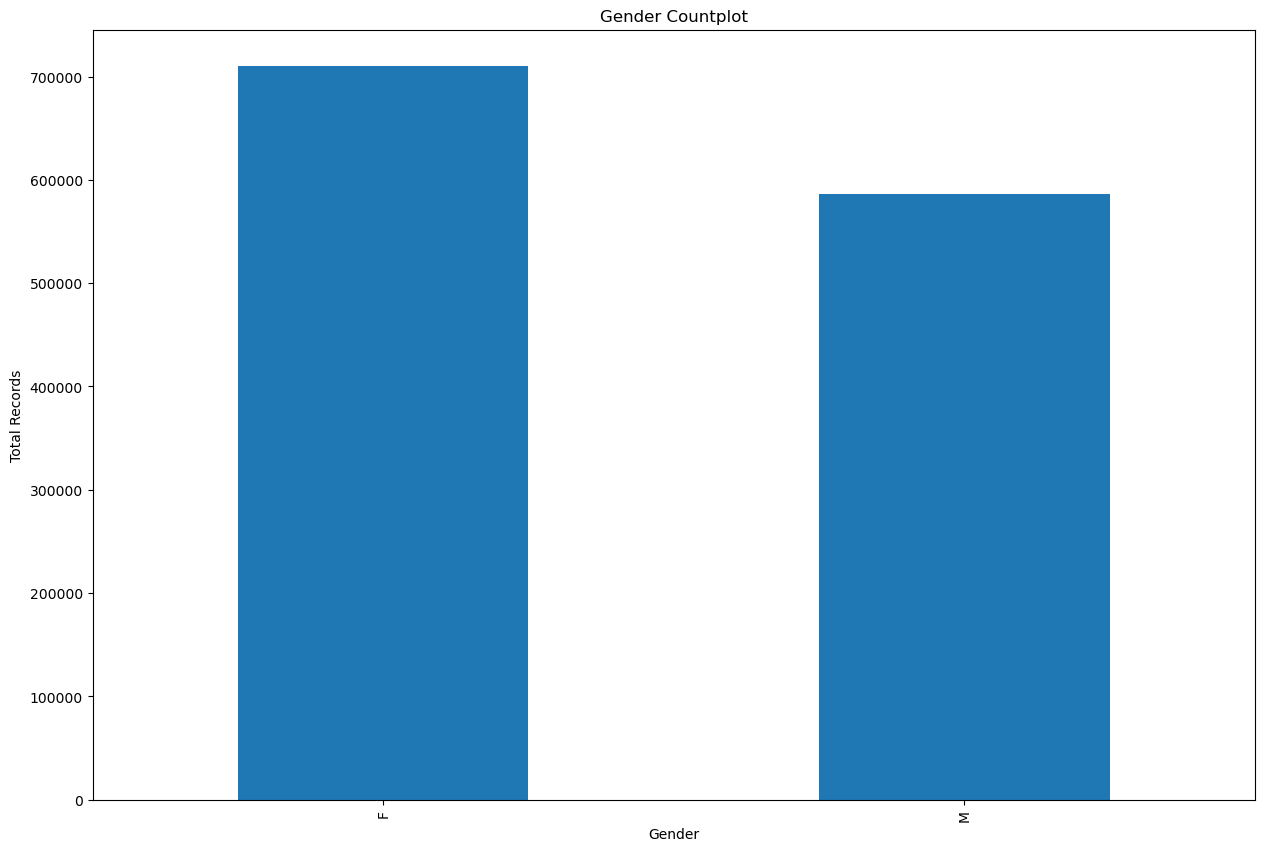

In [20]:
df['gender'].value_counts().plot(kind = 'bar')
plt.title("Gender Countplot")
plt.xlabel("Gender")
plt.ylabel("Total Records")
plt.show()

In [21]:
X = df.drop(['is_fraud'], axis = 1)
y = df['is_fraud'].values.reshape(-1, 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101,
                                     shuffle = True, stratify = y)

In [23]:
print("The shape of the input data: {}".format(X.shape))
print("The shape of the output data: {}".format(y.shape))

The shape of the input data: (1296675, 22)
The shape of the output data: (1296675, 1)


In [24]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [25]:
print("The shape of the train data: {}".format(X_train.shape))
print("The shape of the test data: {}".format(X_test.shape))

The shape of the train data: (1037340, 22)
The shape of the test data: (259335, 22)


In [26]:
fraud_cases = df[df['is_fraud'] == 1]
non_fraud_cases = df[df['is_fraud'] == 0]

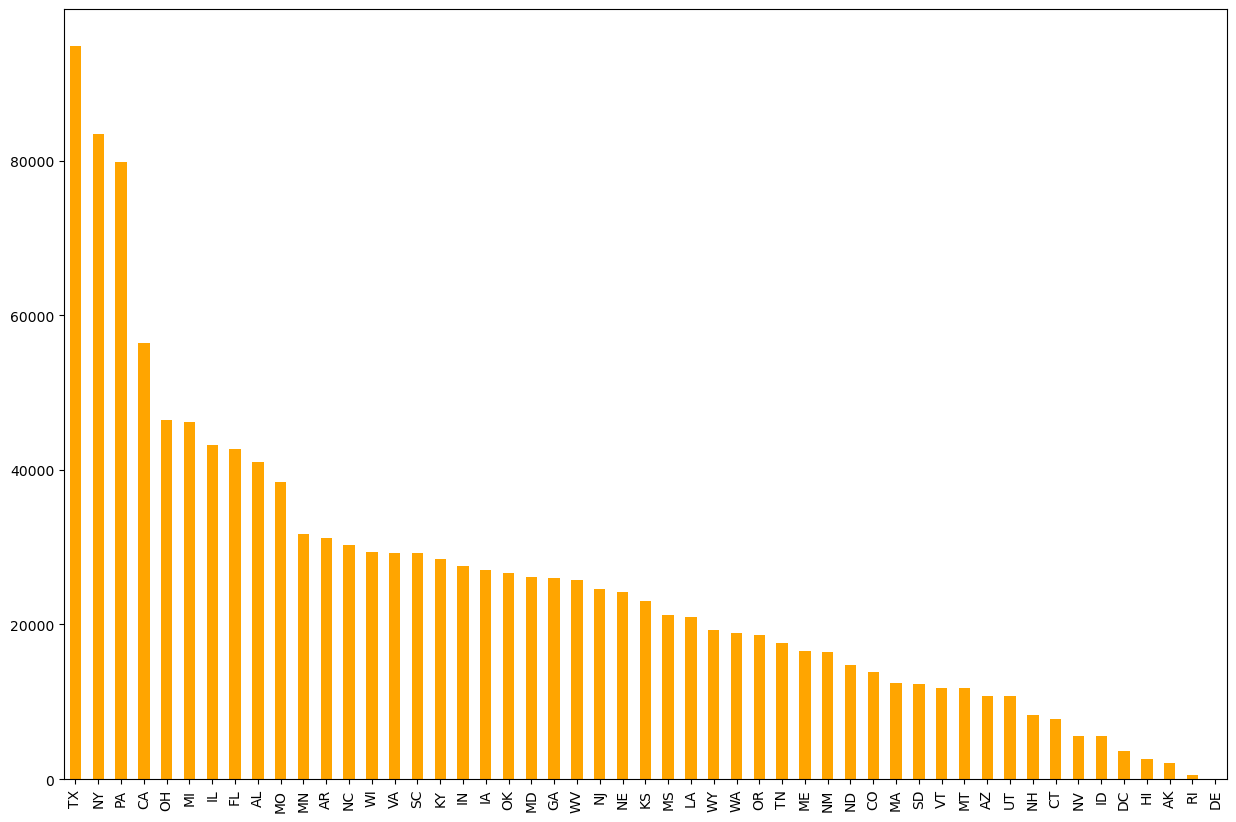

In [27]:
df['state'].value_counts().plot(kind = 'bar', color = 'orange')
plt.show()

In [28]:
df.head()

,cc_num,merchant,category,amt,first,last,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,year,month,day,hour,minute,second
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,2019,1,1,0,0,18
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,2019,1,1,0,0,44
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0,2019,1,1,0,0,51
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,2019,1,1,0,1,16
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,2019,1,1,0,3,6


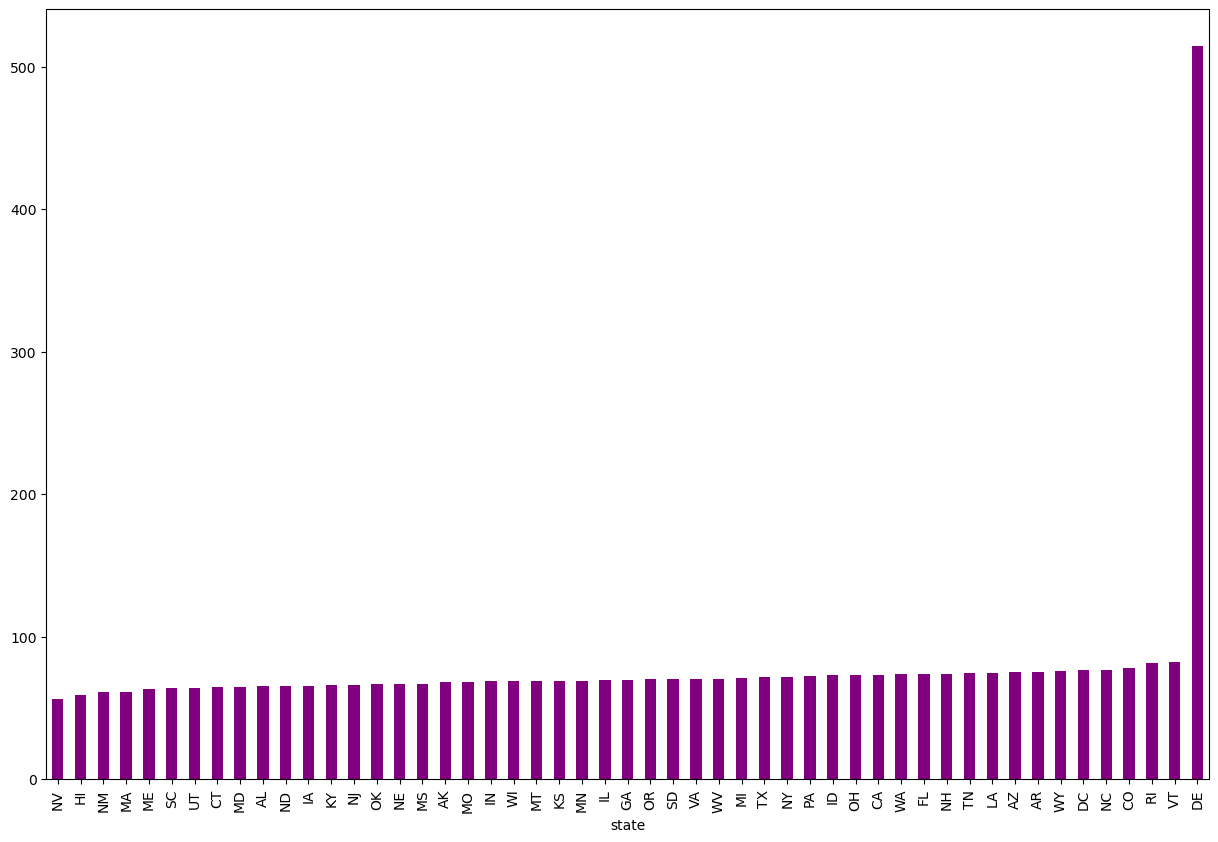

In [29]:
df.groupby(by = 'state')['amt'].mean().sort_values().plot(kind = 'bar', color = 'purple')
plt.show()

<AxesSubplot: xlabel='cc_num'>

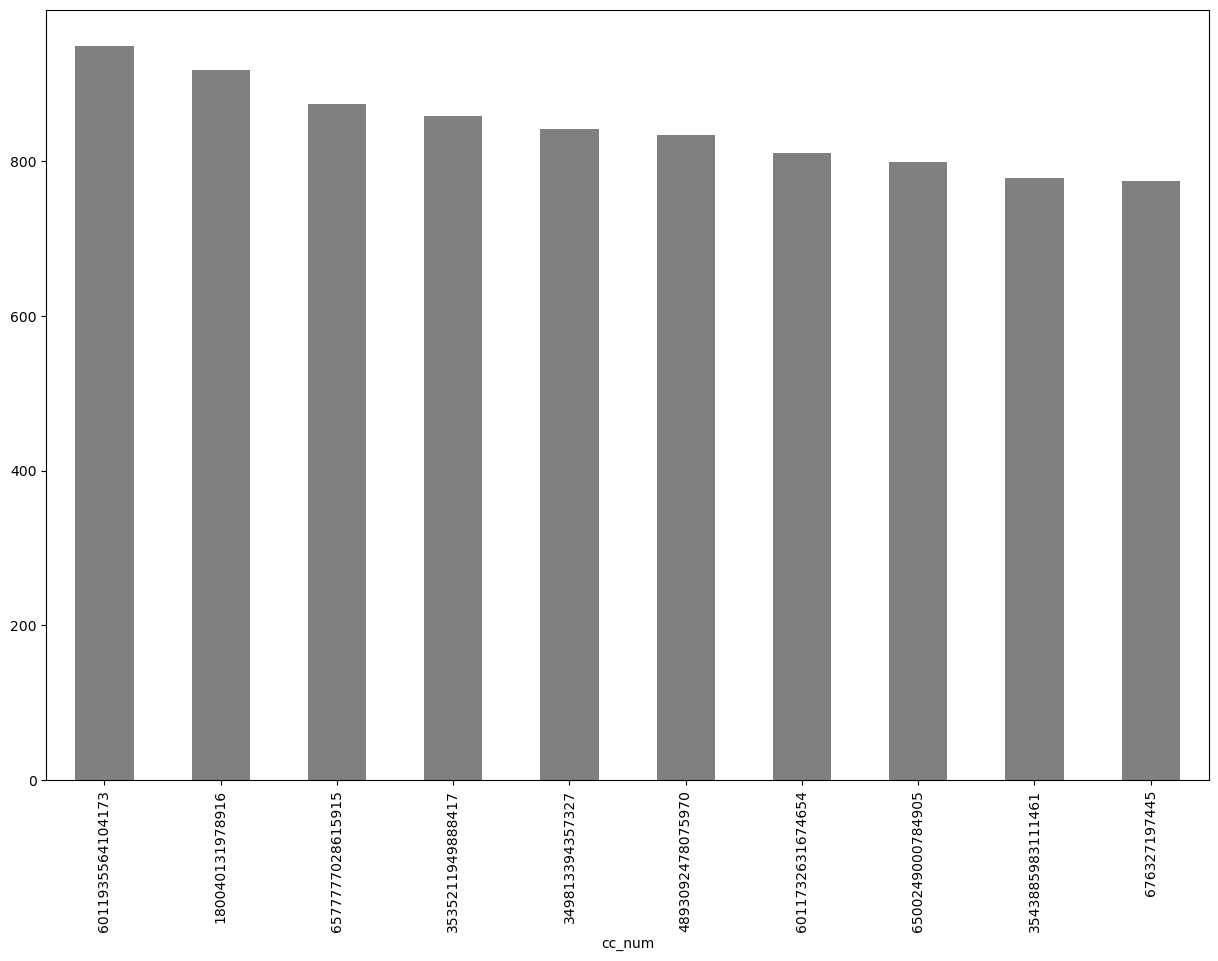

In [30]:
df.groupby(by = 'cc_num')['amt'].mean().sort_values(ascending = False)[0: 10].plot(kind = 'bar', color = 'grey')

<AxesSubplot: >

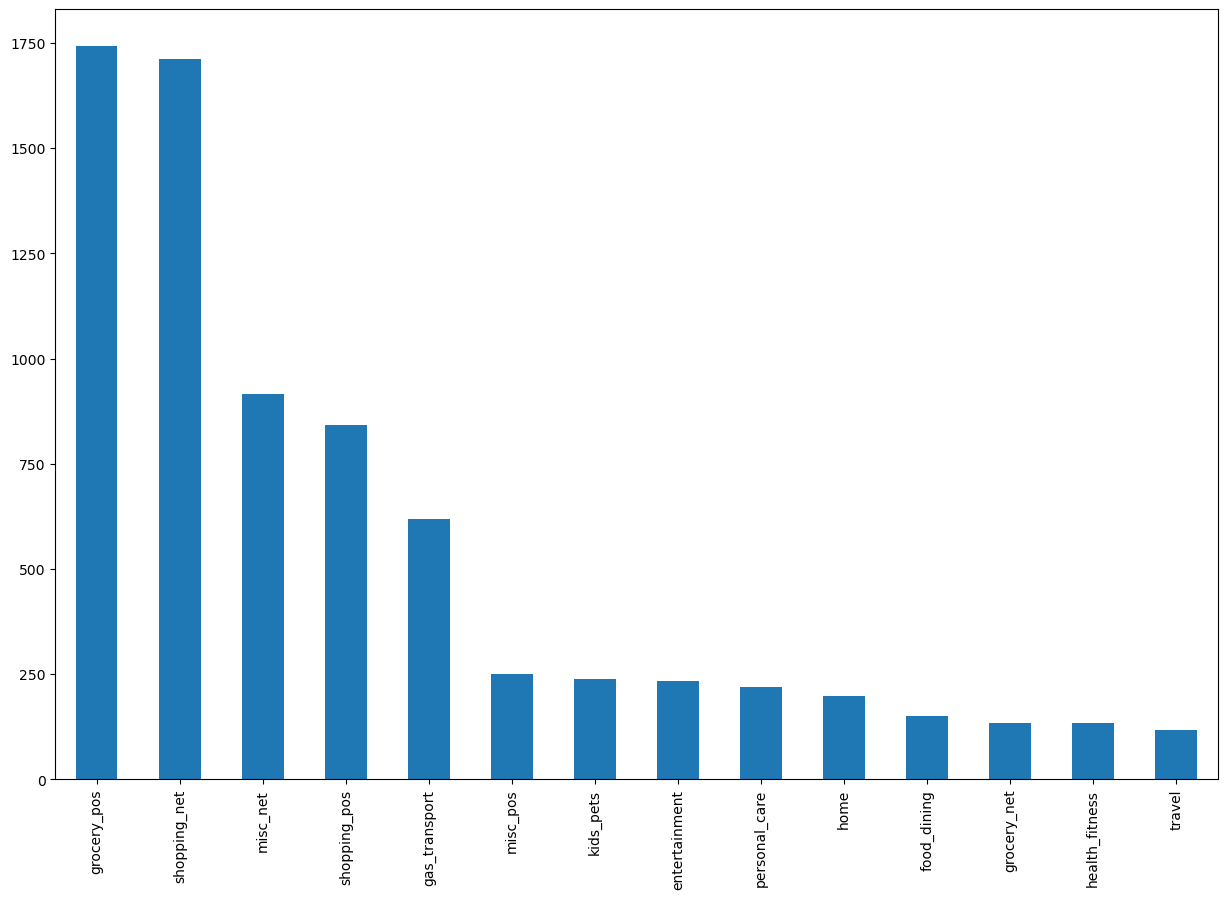

In [31]:
fraud_cases['category'].value_counts().plot(kind = 'bar')

<AxesSubplot: >

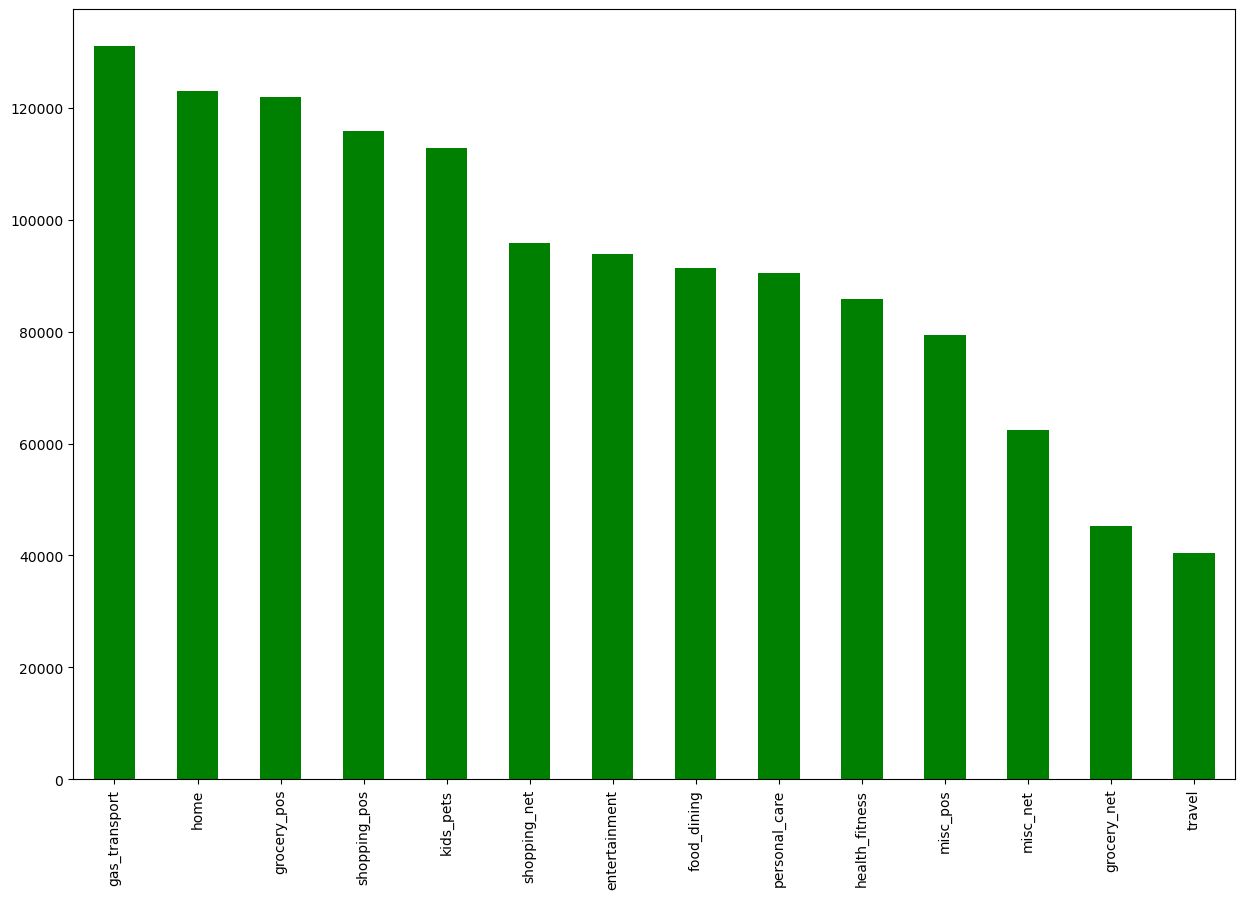

In [32]:
non_fraud_cases['category'].value_counts().plot(kind = 'bar', color = 'green')

### One-Hot Encoding

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
categorical_features = ['merchant','category', 'first', 'last', 'gender', 
                        'city', 'state', 'job', 'year', 'month', 'day',
                       'hour', 'minute', 'second']
X_train_numerical = X_train.drop(categorical_features, axis = 1)
X_test_numerical = X_test.drop(categorical_features, axis = 1)

In [35]:
X_train_numerical.head()

,cc_num,amt,zip,lat,long,city_pop,merch_lat,merch_long
0,4990494243023,7.26,21524,39.6967,-78.8031,626,40.132268,-78.789745
1,4783226709001,141.52,67556,38.5957,-99.5540,320,38.260858,-99.232385
2,4025612008285111,102.24,15829,41.1762,-79.1976,1274,41.746414,-78.644963
3,343668971234893,14.11,29061,33.9349,-80.8449,13717,34.459562,-81.702706
4,213156747557083,8.44,91206,34.1556,-118.2322,172817,33.768442,-119.193376


In [36]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

In [37]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
X_train_ohe = encoder.fit_transform(X_train_categorical)
X_test_ohe = encoder.transform(X_test_categorical)

In [38]:
from scipy.sparse import hstack

In [39]:
X_train_encoded = hstack((X_train_numerical.values, X_train_ohe))
X_test_encoded = hstack((X_test_numerical.values, X_test_ohe))

In [40]:
X_train_encoded.shape

(1037340, 3178)

### Training an ML Model

In [41]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
# This cell can take about 5 mins as we are training a large dataset
xgb_model = xgb.XGBClassifier(n_estimators = 25, max_depth = 3, random_state = 101)
xgb_model.fit(X_train_encoded, y_train)

[11:41:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=25, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
y_predictions = xgb_model.predict(X_test_encoded)

In [44]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.92      0.64      0.75      1501

    accuracy                           1.00    259335
   macro avg       0.96      0.82      0.88    259335
weighted avg       1.00      1.00      1.00    259335



In [45]:
confusion_matrix(y_test, y_predictions)

array([[257749,     85],
       [   542,    959]], dtype=int64)

### Training an ML Model with Feature Engineering

In [46]:
# Defining utility functions that are used later in code 

def euclidean_distance(lat1, long1, lat2, long2):
    
    dlat = lat2 - lat1
    dlong = long2 - long1
    euclidean_distance = (dlat ** 2 + dlong ** 2) ** 0.5
    
    return euclidean_distance

def big_transaction(data, amount = 5000):
    
    if data > amount:
        return 1
    else:
        return 0

In [47]:
X_train.head()

,cc_num,merchant,category,amt,first,last,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,year,month,day,hour,minute,second
0,4990494243023,fraud_Crona and Sons,kids_pets,7.26,Martin,Ford,M,Corriganville,MD,21524,39.6967,-78.8031,626,Energy engineer,40.132268,-78.789745,2020,6,1,20,58,19
1,4783226709001,fraud_Kiehn Inc,grocery_pos,141.52,Jessica,Garcia,F,Mc Cracken,KS,67556,38.5957,-99.5540,320,Film/video editor,38.260858,-99.232385,2020,1,31,6,32,36
2,4025612008285111,fraud_Kuphal-Toy,food_dining,102.24,Krystal,Key,F,Corsica,PA,15829,41.1762,-79.1976,1274,Maintenance engineer,41.746414,-78.644963,2019,6,29,14,53,10
3,343668971234893,"fraud_Berge, Kautzer and Harris",personal_care,14.11,Sally,Moore,F,Hopkins,SC,29061,33.9349,-80.8449,13717,Chiropodist,34.459562,-81.702706,2019,5,9,12,17,23
4,213156747557083,"fraud_Bahringer, Schoen and Corkery",shopping_pos,8.44,Adam,Santos,M,Glendale,CA,91206,34.1556,-118.2322,172817,Advertising account planner,33.768442,-119.193376,2019,3,18,18,48,59


In [63]:
X_train.groupby(by = 'cc_num').mean()['amt']

cc_num
60416207185             57.429747
60422928733             71.454005
60423098130            128.237075
60427851591            113.816227
60487002085             51.407482
                          ...    
4958589671582726883     64.679665
4973530368125489546     81.048785
4980323467523543940     74.790699
4989847570577635369     82.997995
4992346398065154184     69.313852
Name: amt, Length: 983, dtype: float64

In [87]:
df_train = X_train.copy()
df_test = X_test.copy()

df_train['is_fraud'] = y_train
df_test['is_fraud'] = y_test

In [88]:
df_train.head()

,cc_num,merchant,category,amt,first,last,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,year,month,day,hour,minute,second,category_mean,city_mean,state_mean,city_min,city_max,job_mean,euclidean_distance,cc_num_mean,is_fraud
0,4990494243023,fraud_Crona and Sons,kids_pets,7.26,Martin,Ford,M,Corriganville,MD,21524,39.6967,-78.8031,626,Energy engineer,40.132268,-78.789745,2020,6,1,20,58,19,57.604905,63.258911,65.936879,1.02,4215.99,60.036652,0.435773,63.258911,0
1,4783226709001,fraud_Kiehn Inc,grocery_pos,141.52,Jessica,Garcia,F,Mc Cracken,KS,67556,38.5957,-99.5540,320,Film/video editor,38.260858,-99.232385,2020,1,31,6,32,36,116.959903,62.506844,69.539323,1.04,2838.23,78.029582,0.464279,62.506844,0
2,4025612008285111,fraud_Kuphal-Toy,food_dining,102.24,Krystal,Key,F,Corsica,PA,15829,41.1762,-79.1976,1274,Maintenance engineer,41.746414,-78.644963,2019,6,29,14,53,10,51.138962,61.171045,71.804820,1.00,1308.82,64.007485,0.794073,61.171045,0
3,343668971234893,"fraud_Berge, Kautzer and Harris",personal_care,14.11,Sally,Moore,F,Hopkins,SC,29061,33.9349,-80.8449,13717,Chiropodist,34.459562,-81.702706,2019,5,9,12,17,23,48.022896,65.752747,63.164189,1.00,1503.12,71.690800,1.005535,65.752747,0
4,213156747557083,"fraud_Bahringer, Schoen and Corkery",shopping_pos,8.44,Adam,Santos,M,Glendale,CA,91206,34.1556,-118.2322,172817,Advertising account planner,33.768442,-119.193376,2019,3,18,18,48,59,79.648241,67.491494,73.320097,1.01,3923.46,64.898676,1.036219,65.721020,0


In [117]:
# Creating mapper variables to be used to create new features from existing ones
cc_fraud_mean = df_train[df_train['is_fraud'] == 1].groupby(by = 'cc_num').mean()['amt']
cc_fraud_min = df_train[df_train['is_fraud'] == 1].groupby(by = 'cc_num').min()['amt']
cc_fraud_max = df_train[df_train['is_fraud'] == 1].groupby(by = 'cc_num').max()['amt']

cc_non_fraud_mean = df_train[df_train['is_fraud'] == 0].groupby(by = 'cc_num').mean()['amt']
cc_non_fraud_min = df_train[df_train['is_fraud'] == 0].groupby(by = 'cc_num').min()['amt']
cc_non_fraud_max = df_train[df_train['is_fraud'] == 0].groupby(by = 'cc_num').max()['amt']

In [118]:
# Creating new features from train data
X_train['category_mean'] = X_train['category'].map(X_train.groupby(by = 'category').mean()['amt'])
X_train['city_mean'] = X_train['city'].map(X_train.groupby(by = 'city').mean()['amt'])
X_train['state_mean'] = X_train['state'].map(X_train.groupby(by = 'state').mean()['amt'])
X_train['city_min'] = X_train['city'].map(X_train.groupby(by = 'city').min()['amt'])
X_train['city_max'] = X_train['city'].map(X_train.groupby(by = 'city').max()['amt'])
X_train['job_mean'] = X_train['job'].map(X_train.groupby(by = 'job').mean()['amt'])
X_train['cc_num_mean'] = X_train['cc_num'].map(X_train.groupby(by = 'cc_num').mean()['amt'])
X_train['cc_num_fraud_mean'] = X_train['cc_num'].map(cc_fraud_mean)
X_train['cc_num_non_fraud_mean'] = X_train['cc_num'].map(cc_non_fraud_mean)
X_train['cc_num_non_fraud_min'] = X_train['cc_num'].map(cc_non_fraud_min)
X_train['cc_num_non_fraud_max'] = X_train['cc_num'].map(cc_non_fraud_max)

# Creating new features from test data
X_test['category_mean'] = X_test['category'].map(X_train.groupby(by = 'category').mean()['amt'])
X_test['city_mean'] = X_test['city'].map(X_train.groupby(by = 'city').mean()['amt'])
X_test['state_mean'] = X_test['state'].map(X_train.groupby(by = 'state').mean()['amt'])
X_test['city_min'] = X_test['city'].map(X_train.groupby(by = 'city').min()['amt'])
X_test['city_max'] = X_test['city'].map(X_train.groupby(by = 'city').max()['amt'])
X_test['job_mean'] = X_test['job'].map(X_train.groupby(by = 'job').mean()['amt'])
X_test['cc_num_mean'] = X_test['cc_num'].map(X_train.groupby(by = 'cc_num').mean()['amt'])
X_test['cc_num_fraud_mean'] = X_test['cc_num'].map(cc_fraud_mean)
X_test['cc_num_non_fraud_mean'] = X_test['cc_num'].map(cc_non_fraud_mean)
X_test['cc_num_non_fraud_min'] = X_test['cc_num'].map(cc_non_fraud_min)
X_test['cc_num_non_fraud_max'] = X_test['cc_num'].map(cc_non_fraud_max)

In [119]:
lat1 = X_train['lat']
long1 = X_train['long']
lat2 = X_train['merch_lat']
long2 = X_train['merch_long']

X_train['euclidean_distance'] = euclidean_distance(lat1, long1, lat2, long2)

In [120]:
lat1 = X_test['lat']
long1 = X_test['long']
lat2 = X_test['merch_lat']
long2 = X_test['merch_long']

X_test['euclidean_distance'] = euclidean_distance(lat1, long1, lat2, long2)

In [121]:
categorical_features = ['cc_num', 'merchant','category', 'first', 'last', 'gender', 
                        'city', 'state', 'job', 'year', 'month', 'day',
                       'hour', 'minute', 'second']
X_train_numerical = X_train.drop(categorical_features, axis = 1)
X_test_numerical = X_test.drop(categorical_features, axis = 1)

In [123]:
# filling the missing values obtained as grouping with 0
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)

In [124]:
df_train = X_train.copy()
df_test = X_test.copy()

df_train['is_fraud'] = y_train
df_test['is_fraud'] = y_test

<AxesSubplot: >

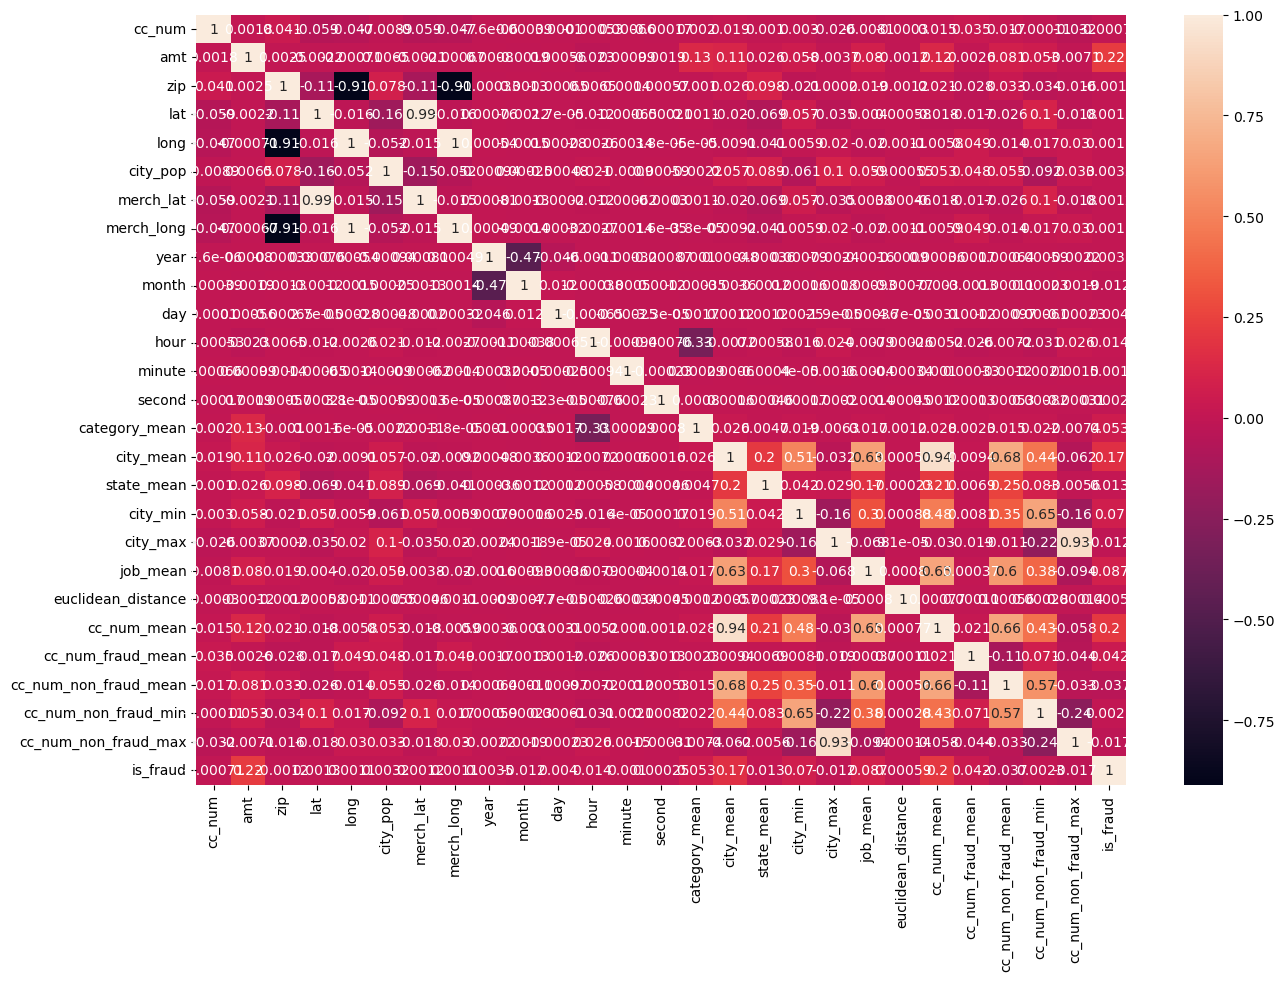

In [125]:
sns.heatmap(df_train.corr(), annot = True)

In [126]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

In [127]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
X_train_ohe = encoder.fit_transform(X_train_categorical)
X_test_ohe = encoder.transform(X_test_categorical)

In [128]:
X_train_encoded = hstack((X_train_numerical.values, X_train_ohe))
X_test_encoded = hstack((X_test_numerical.values, X_test_ohe))

In [129]:
# This cell can take about 5-10 mins as we are training a large dataset
xgb_model = xgb.XGBClassifier(n_estimators = 25, max_depth = 3, random_state = 101, n_jobs = 30)
xgb_model.fit(X_train_encoded, y_train)

[12:20:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=25, n_jobs=30,
              num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [130]:
y_predictions = xgb_model.predict(X_test_encoded)

In [131]:
print(classification_report(y_predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    258250
           1       0.68      0.94      0.79      1085

    accuracy                           1.00    259335
   macro avg       0.84      0.97      0.89    259335
weighted avg       1.00      1.00      1.00    259335



In [132]:
confusion_matrix(y_test, y_predictions)

array([[257766,     68],
       [   484,   1017]], dtype=int64)

### Logistic Regression

In [178]:
from sklearn.linear_model import LogisticRegression

In [179]:
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
y_predictions = model.predict(X_test_encoded)

In [180]:
print(classification_report(y_predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     32379
           1       0.07      0.37      0.12        38

    accuracy                           0.99     32417
   macro avg       0.54      0.68      0.56     32417
weighted avg       1.00      0.99      1.00     32417



In [181]:
confusion_matrix(y_test, y_predictions)

array([[32205,    24],
       [  174,    14]], dtype=int64)

In [183]:
model.coef_

array([[ 2.56209570e-03, -2.72775036e-02,  8.39480799e-03, ...,
        -9.29601604e-06, -2.67985319e-05,  1.36294912e-06]])

### SMOTE Oversampling

In [192]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 101)

X_train_oversampled_tuple = smote.fit_resample(X_train_encoded, y_train)

In [193]:
# Reading the input and output from the tuple
X_train_oversampled = X_train_oversampled_tuple[0]
y_train_oversampled = X_train_oversampled_tuple[1]

In [194]:
print("The initial shape of the training dataset: {}".format(X_train_encoded.shape))
print("The shape of oversampled training dataset: {}".format(X_train_oversampled.shape))

The initial shape of the training dataset: (1264258, 4148)
The shape of oversampled training dataset: (2513880, 4148)


In [195]:
# This cell can take about 5-10 mins as we are training a large dataset
xgb_model = xgb.XGBClassifier(n_estimators = 25, max_depth = 3, random_state = 101, n_jobs = 30)
xgb_model.fit(X_train_oversampled, y_train_oversampled)

[22:05:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=25, n_jobs=30,
              num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [196]:
y_predictions = xgb_model.predict(X_test_encoded)

In [197]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     32229
           1       0.24      0.77      0.37       188

    accuracy                           0.98     32417
   macro avg       0.62      0.88      0.68     32417
weighted avg       0.99      0.98      0.99     32417



### Random Undersampling

In [201]:
from imblearn.under_sampling import RandomUnderSampler

random_undersampler = RandomUnderSampler(random_state = 101, sampling_strategy = 'majority')

X_train_undersampled_tuple = random_undersampler.fit_resample(X_train_encoded, y_train)

In [202]:
# Reading the input and output from the tuple
X_train_undersampled = X_train_undersampled_tuple[0]
y_train_undersampled = X_train_undersampled_tuple[1]

In [203]:
print("The initial shape of the training dataset: {}".format(X_train_encoded.shape))
print("The shape of undersampled training dataset: {}".format(X_train_undersampled.shape))

The initial shape of the training dataset: (1264258, 4148)
The shape of oversampled training dataset: (14636, 4148)


In [210]:
# This cell can take about 5-10 mins as we are training a large dataset
xgb_model = xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 101, n_jobs = 30)
xgb_model.fit(X_train_undersampled, y_train_undersampled)

[22:10:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=30,
              num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [211]:
y_predictions = xgb_model.predict(X_test_encoded)

In [212]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     32229
           1       0.19      0.97      0.31       188

    accuracy                           0.98     32417
   macro avg       0.59      0.97      0.65     32417
weighted avg       1.00      0.98      0.98     32417



### Random Oversampling

In [214]:
from imblearn.over_sampling import RandomOverSampler

random_oversampler = RandomOverSampler(random_state = 101, sampling_strategy = 'minority')

X_train_oversampled_tuple = random_oversampler.fit_resample(X_train_encoded, y_train)

In [215]:
# Reading the input and output from the tuple
X_train_oversampled = X_train_oversampled_tuple[0]
y_train_oversampled = X_train_oversampled_tuple[1]

In [216]:
print("The initial shape of the training dataset: {}".format(X_train_encoded.shape))
print("The shape of oversampled training dataset: {}".format(X_train_oversampled.shape))

The initial shape of the training dataset: (1264258, 4148)
The shape of oversampled training dataset: (2513880, 4148)


In [223]:
# This cell can take about 5-10 mins as we are training a large dataset
xgb_model = xgb.XGBClassifier(n_estimators = 25, max_depth = 3, random_state = 101, n_jobs = 30)
xgb_model.fit(X_train_oversampled, y_train_oversampled)

[22:24:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=25, n_jobs=30,
              num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [224]:
y_predictions = xgb_model.predict(X_test_encoded)

In [225]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     32229
           1       0.14      0.95      0.25       188

    accuracy                           0.97     32417
   macro avg       0.57      0.96      0.61     32417
weighted avg       0.99      0.97      0.98     32417



In [226]:
df.head()

,merchant,category,amt,first,last,gender,city,state,zip,lat,...,unix_time,merch_lat,merch_long,is_fraud,year,month,day,hour,minute,second
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,Moravian Falls,NC,28654,36.0788,...,1325376018,36.011293,-82.048315,0,2019,1,1,0,0,18
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,Orient,WA,99160,48.8878,...,1325376044,49.159047,-118.186462,0,2019,1,1,0,0,44
2,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,Malad City,ID,83252,42.1808,...,1325376051,43.150704,-112.154481,0,2019,1,1,0,0,51
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,Boulder,MT,59632,46.2306,...,1325376076,47.034331,-112.561071,0,2019,1,1,0,1,16
4,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,Doe Hill,VA,24433,38.4207,...,1325376186,38.674999,-78.632459,0,2019,1,1,0,3,6


In [227]:
X_train_numerical.head()

,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,euclidean_distance
424954,166.77,34.5906,-95.3800,1760,1341858861,35.263565,-96.310568,1.148407
414822,29.14,38.8954,-77.1633,207410,1341600345,38.147359,-76.818658,0.823616
1174163,1.72,36.8020,-87.8286,13422,1367720732,36.436757,-86.989457,0.915185
371611,105.86,38.8938,-86.5246,1228,1340273421,39.642489,-87.294020,1.073565
1108407,95.27,44.8816,-73.6408,2148,1365240467,44.293910,-74.248301,0.845244


In [228]:
X_train_categorical.head()

,merchant,category,first,last,gender,city,state,job,zip,year,month,day,hour,minute,second
424954,"fraud_Hills, Hegmann and Schaefer",health_fitness,Donna,Davis,F,Clayton,OK,Occupational psychologist,74536,2019,7,9,18,34,21
414822,fraud_Nolan-Williamson,kids_pets,David,Lewis,M,Arlington,VA,Mudlogger,22213,2019,7,6,18,45,45
1174163,fraud_Johns-Hoeger,entertainment,John,Clarke,M,Cadiz,KY,Commissioning editor,42211,2020,5,5,2,25,32
371611,fraud_Strosin-Cruickshank,grocery_pos,Erica,Briggs,F,Oolitic,IN,Counsellor,47451,2019,6,21,10,10,21
1108407,fraud_Conroy-Cruickshank,gas_transport,Toni,Gomez,F,Altona,NY,"Surveyor, land/geomatics",12910,2020,4,6,9,27,47
